<a href="https://colab.research.google.com/github/aissahm/image_analysis/blob/main/project_1_parallele_running_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image analysis - Project 1**

In [ ]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import os
from google.colab import files

!pip install ipython-autotime
%load_ext autotime

We create the folders we need to store the intermediate output and final outputs.

In [2]:
ycbcrfolderpath = "ycbcrplates"
os.mkdir(ycbcrfolderpath)

time: 1.31 ms


## **Introduction**

In this task we will evaluate the potential of three image operators, when used in sequence, to extract image features suitable for license plate image detection (i.e., features that must highlight the caracters of a plate). In the current directory, you will find the images of the plates and their binary masks. You will also find three random splits of the original images into training and testing sets. The task consists of the following steps, which can be applied to any of these sets.

1. Step 1: Dataset composition.
2. Step 2: Batch (z-score) normalization.
3. Step 3: Creation of a random kernel bank.
4. Step 4: Convolution with the random kernel bank. 
5. Step 5: Rectified Linear Unit activation (ReLU).

These steps are presented in the next sections.

## **Dataset composition**

You must create a subimage (patch) dataset by extracting regions of interest with size W × H pixels, center at each position (x,y) of the original images, and stride (displacement between them) of (Dx,Dy) pixels.

The plate masks (avaliable annotation) can be used in this step only to verify if your choice for W, H, Dx, and Dy is suitable to not miss any plate from the training set. That is, for the corresponding testing set, you will simply use the same parameters learned in the training set.

In this step, using the training set only, you must also define a threshold on the percentage of plate pixels that fall inside a subimage to consider it from class 1 (background) or class 2 (plate/foreground). Note that this will create a difficulty for a future plate detection since subimages with parts of a plate might be considered background. In this sense, we might need to further process those images in the future to avoid classification errors.

After creating the subimages of a same size W × H, you must convert each subimage into a multiband image by pseudo colorizing it based on a Red-Green-Blue color table (e.g., from blue to red) and then convert it into an uncorrelated color space (e.g., Y-Cb-Cr or L-a-b).


#### **From grayscale to YCbCr**

We create a function that will transform the grayscale image with one channel to a YCbCr image with 3 channels. We first transform the image into an RGB image, and then to a YCbCr image.

In [3]:
#function that saves an image
def saveImage(image, imagefullpath):
  cv2.imwrite(imagefullpath, image)

#Mapping from grayscale pixel to RGB using color table
def fromGrayscaleToRGBMapping(pixel, H):
  V = pixel / H
  V = (6 - 2) * V + 1
  r_p = H * max(0, (3- abs(V-4) - abs(V-5))/2 )
  g_p = H * max(0, (4- abs(V-2) - abs(V-4))/2 )
  b_p = H * max(0, (3- abs(V-1) - abs(V-2))/2 )
  return [r_p, g_p, b_p]

#Transform the grayscale image with one channel into an RGB image with 3 channels
def fromGrayscaleToRGB(grayscaleimage, bits):
  if len(grayscaleimage.shape) !=2:
    print ("Error: image is not a grayscale image")
    return 0
  
  H = 2**bits -1

  #we initiate an rgb image with 3 channels with same dimensions as grayscale image
  rgbimage = np.zeros((grayscaleimage.shape[0], grayscaleimage.shape[1], 3))
  i = 0
  while i < grayscaleimage.shape[0]:
    j = 0
    while j < grayscaleimage.shape[1]:
      r_p, g_p, b_p = fromGrayscaleToRGBMapping(grayscaleimage[i][j], H)
      rgbimage[i][j][0] = r_p
      rgbimage[i][j][1] = g_p
      rgbimage[i][j][2] = b_p
      
      j +=1
    i +=1
  
  return rgbimage

#Transform an RGB image with 3 channels into a YCbCr image with 3 channels
def fromRGBToYCbCr(rgbimage, bits):
  conversionMatrix = np.array([[0.299, 0.587, 0.144], [-0.169, -0.331, 0.500], [0.500, -0.419, -0.081]])
  bias = np.array([0, 2**(bits - 1), 2**(bits -1)])
  YCbCrimage = np.zeros((rgbimage.shape[0], rgbimage.shape[1], rgbimage.shape[2]))

  i = 0
  while i < rgbimage.shape[0]:
    j = 0
    while j < rgbimage.shape[1]:
      YCbCrimage[i][j] = conversionMatrix @ rgbimage[i][j] + bias
      j += 1
    i += 1

  return YCbCrimage

#Main function that converts a grayscale image with 1 channel to a YCbCr image with 3 channels
def fromGrayscaleToYCbCr(image, bits):
  rgbimage = fromGrayscaleToRGB(image, bits)
  if len(rgbimage.shape) < 3:
    return 0
  return fromRGBToYCbCr(rgbimage, bits)

time: 99.5 ms


We test the functions above with a grayscale image exmaple:

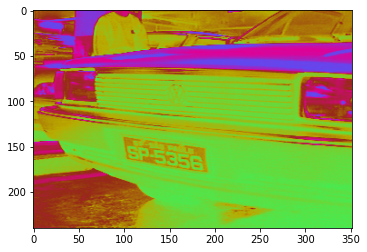

time: 1.33 s


In [ ]:
grayscaleimg = cv2.imread("/content/plates/orig_0001.png", cv2.IMREAD_GRAYSCALE)

ycbcrimg = fromGrayscaleToYCbCr(grayscaleimg, 8)

plt.imshow(ycbcrimg.astype('uint8'))
plt.show()

**Now, we loop through each image inside the "plates" folder to convert them into YCbCr images and save the images inside the folder "ycbcrplates/".**

In [4]:
directory = '/content/plates/'

ycbcrdirectory = "/content/ycbcrplates/"

i = 0 
for filename in os.listdir(directory):
  if "orig" in filename:
    grayscaleimg = cv2.imread(directory + filename, cv2.IMREAD_GRAYSCALE)
    ycbcrimg = fromGrayscaleToYCbCr(grayscaleimg, 8)
    ycbcrimg = ycbcrimg.astype('uint8')

    ycbcrimagepath = ycbcrdirectory + filename
    cv2.imwrite(ycbcrimagepath, ycbcrimg)
    i += 1

print("Done,", i, " images from 'plates/' converted to YCbCr.")

Done, 200  images from 'plates/' converted to YCbCr.
time: 4min 11s


**We first create a function that returns the percentage of plate pixels contained in a subimage**

We need the sizes W x H, the coordinates of the center of the subimage (x,y).

In [5]:
#returns the number of pixels representing the plate in the mask
def returnPlateNumberPixelsFromMask(maskImg):
  #maskImg = cv2.imread(maskPath)
  return maskImg.sum()/(3*255)

#given width x height, and center coordinates of subimage, returns number of plate pixels contained in subimage
def returnPlateNumberPixelsCovBySubimage(width, height, xcenter, ycenter, maskImg):
  xstart = xcenter - width//2
  xend = xcenter + width//2
  ystart = ycenter - height//2
  yend = ycenter + height//2
  subImg = maskImg[ystart:yend+1,xstart: xend+1,:]

  return subImg.sum()/(3*255)

time: 4.89 ms


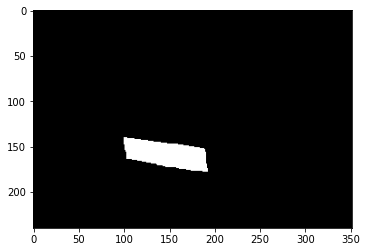

time: 142 ms


In [ ]:
test_image_path = "/content/plates/mask_0001.png"

#Import image
img = cv2.imread(test_image_path)

#Show the image with matplotlib
plt.imshow(img)
plt.show()

In [ ]:
w = 150
h = 100
x = 150
y = 150

print(returnPlateNumberPixelsCovBySubimage(w, h, x, y, img))
print()
print(returnPlateNumberPixelsFromMask(img))

2274.0

2274.0
time: 4.76 ms


#### **Selecting the values for the parameters**

In [6]:
def scanOriginalImageUsingSubImagesWith(width, height, xstride, ystride, imagepath, thresholdForPlateClass):
  
  imageToScan = cv2.imread(imagepath)
  plateNumberPixelsInImageToScan = returnPlateNumberPixelsFromMask(imageToScan)

  #statistics
  numberSubImages = 0
  numberSubImagesClassPlate = 0 #number of images wich contain the threshold of plate percentage
  numberSubImagesContainingAllPlate = 0

  #initializing scanning parameters 
  xcenter_initial = width // 2
  ycenter_initial = height // 2
  yfinal = imageToScan.shape[0] - height // 2 - 1
  xfinal = imageToScan.shape[1] - width // 2 - 1
  ycenter = ycenter_initial
  xcenter = xcenter_initial
  
  #we scan the original image from left to right, top to bottom
  while ycenter <= yfinal:
    
    #We make sure we cover the entire original image 
    #on the last strides on vertical and/or horizontal axes
    if xfinal - xcenter < xstride:
      xcenter = xfinal
    if yfinal - ycenter < ystride:
      ycenter = yfinal
    
    plateNumberPixelsInSubimage = returnPlateNumberPixelsCovBySubimage(width, height, xcenter, ycenter, imageToScan)
    #percentage of plate
    platePercentageCovered = plateNumberPixelsInSubimage / plateNumberPixelsInImageToScan
    
    #percentage of total pixels in subimage
    #platePercentageCovered = plateNumberPixelsInSubimage / (width*height)

    #Increment
    xcenter += xstride
    if xcenter > xfinal:
      xcenter = xcenter_initial
      ycenter += ystride
    
    #statistics
    numberSubImages += 1
    if platePercentageCovered >= thresholdForPlateClass:
      numberSubImagesClassPlate += 1
    if platePercentageCovered == 1.0:
      numberSubImagesContainingAllPlate += 1
    
  #print statistics:
  #print("Number of subimages created ", numberSubImages - 1)
  #print("Number of subimages with threshold pixels of plate ", numberSubImagesClassPlate)
  #print("Number of subimages containing all the plate ", numberSubImagesContainingAllPlate)

  return [numberSubImagesContainingAllPlate, numberSubImagesClassPlate, numberSubImages]

time: 26.2 ms


We test the functions created above with one example before looping through all the 3 training sets.

In [7]:
w = 187
h = 75
dx = 40
dy = 20
test_image_path = "/content/plates/mask_0001.png"

threshold = 0.9

scanOriginalImageUsingSubImagesWith(w, h, dx, dy, test_image_path, threshold)

[4, 9, 45]

time: 18.8 ms


Now that everything is working as expected, we create an array containing the path to the masks to perform the tests on the entire training sets. 

In [8]:
#given a text file containing the name of training images return pathfile of respective masks
def returnMaskImagesPathArray(trainTextPath):
  mask_images_path_array = []
  train_images_array = []
  with open(trainTextPath, 'r') as file:
      data = file.read().replace('\n', ';')
      train_images_array = data.split(";")
  for train_image_str in train_images_array:
    mask_image_str = train_image_str.replace("./plates/orig", "/content/plates/mask")
    if len(mask_image_str) > 0:
      mask_images_path_array.append(mask_image_str)

  return mask_images_path_array

#given a text file containing the name of training images return pathfile of respective images
def returnImagesPathArray(trainTextPath):
  images_path_array = []
  train_images_array = []
  with open(trainTextPath, 'r') as file:
      data = file.read().replace('\n', ';')
      train_images_array = data.split(";")
  for train_image_str in train_images_array:
    image_str = train_image_str.replace("./plates", "/content/plates")
    if len(image_str) > 0:
      images_path_array.append(image_str)
  return images_path_array

time: 22.2 ms


We select manually the values of W, H, Dx, Dy. 

We define the variable "threshold" as the percentage of pixels from the plate contained in a subimage to classify the subimage as class 2 "plate". If the percentage is below that threshold, we classify the subimage as belonging to class 1 "background".

In [ ]:
w = 187
h = 95
dx = 40
dy = 20
threshold = 0.9

totalNumberSubimagesCreated = 0
totalNumberImagesWithPlatesNotCovered = 0
listTrainImagesWithPlatesNotCovered = []

mask_images_path_array = returnMaskImagesPathArray("/content/train2.txt")

for train_mask_imagepath in mask_images_path_array:
  nImagesContainingAllPlate, nImagesClassPlate, nTotalSubimages = scanOriginalImageUsingSubImagesWith(w, h, dx, dy, train_mask_imagepath, threshold)
  totalNumberSubimagesCreated += nTotalSubimages

  if nImagesContainingAllPlate == 0:
    totalNumberImagesWithPlatesNotCovered += 1
    listTrainImagesWithPlatesNotCovered.append(train_mask_imagepath)

print("Training set size: ", len(mask_images_path_array))
print("Total number images without plates found: ", totalNumberImagesWithPlatesNotCovered)
print("Total subimages created from training set: ", totalNumberSubimagesCreated)


Training set size:  100
Total number images without plates found:  0
Total subimages created from training set:  4000
time: 339 ms


Runnning various values of the parameters, we get the following minimal values in order to make sure that we have at least one subimage of class 2 from each original image, as well as at least one subimage containing the entire plate inside it.



**Parameters:**

First training set: w = 171, h = 71, dx = 40, dy = 10, threshold = 0.9

Second training set: w = 171, h = 71, dx = 40, dy = 10, threshold = 0.9

Third training set: w = 171, h = 75, dx = 40, dy = 10, threshold = 0.9




In order to increase the chances of success of getting at least one subimage containing the plate with the minimum threshold on the test sets, we increase by 10% the values of W and H. This will also allow us to decrease the total number of subimages from all images from 8500 to 8000. 

**Conclusion:**

1. W = 187 pixels
2. H = 81 pixels

3. Dx = 40 pixels
4. Dy = 10 pixels

(Note: W and H must be odd numbers since the subimage is centered at a given pixel.)



In [9]:
#parameters array [w, h, dx, dy, threshold]
parameters_array = [187, 95, 40, 20, 0.9]

#save parameters in param.txt
with open ('param.txt','w') as f:
 for parameterelem in parameters_array:
     f.write(str(parameterelem)+'\n')

time: 2.53 ms


### **Creating all the subimages from the training sets**

In [10]:
#we set the parameters values for w, h, dx, dy
w = 187
h = 95
dx = 40
dy = 20
threshold = 0.9

time: 1.46 ms


In [11]:
#returns mask for correspoinding image
def returnMaskPathFromImagePath(imagePath):
  return imagePath.replace("orig", "mask") 

#returns the ID of the original image
def returnOriginalimagename(imagename):
  originalImagename = imagename.replace(".png", "")
  originalImagename = originalImagename.replace(" ", "")
  return originalImagename

#saving subimage into folder
def saveSubimage(width, height, xcenter, ycenter, subimageClass, outputFolderPath, imagename, subImg):
  originalImagename = returnOriginalimagename(imagename)
  subImagename = originalImagename + "_" + str(width) + "_" + str(height) + "_" + str(int(xcenter)) + "_" + str(int(ycenter)) + "_" + subimageClass
  subimageFullpath = outputFolderPath + subImagename + ".png"
  # Saving the image 
  cv2.imwrite(subimageFullpath, subImg) 

#class as percentage of pixels from plate
def returnSubimgClass(percentagePlateCovered, thresholdForPlateClass):
  if percentagePlateCovered >= thresholdForPlateClass:
    return "2"
  return "1"

#class as percentage of total pixels in subimage
def returnSubimageClass(percentagePlateCovered, thresholdForPlateClass):
  if percentagePlateCovered >= thresholdForPlateClass:
    return "2"
  return "1" 

#return the subimage of interest
def returnSubimageWith(width, height, xcenter, ycenter, maskImg):
  xstart = xcenter - width//2
  xend = xcenter + width//2
  ystart = ycenter - height//2
  yend = ycenter + height//2
  return maskImg[ystart:yend+1,xstart: xend+1,:]

#same code as above, with the addition of creating the subimages and storing them
#information included in filename: originalimagename_width_heigth-xcenter_ycenter_class
def createSubimagesFromTrainingImage(width, height, xstride, ystride, thresholdForPlateClass, imagename, imageFolderPath, maskFolderPath, outputFolderpath):
  
  imagePath = imageFolderPath + imagename
  imageToScan = cv2.imread(imagePath)
  maskname = returnMaskPathFromImagePath(imagename)
  imageMask = cv2.imread(maskFolderPath + maskname, 1)
  
  plateNumberPixelsInImageToScan = returnPlateNumberPixelsFromMask(imageMask)

  #statistics
  numberSubImages = 0
  numberSubImagesClassPlate = 0 #number of images wich contain the threshold of plate percentage

  #initializing scanning parameters 
  xcenter_initial = width // 2
  ycenter_initial = height // 2
  yfinal = imageMask.shape[0] - height // 2 - 1
  xfinal = imageMask.shape[1] - width // 2 - 1
  ycenter = ycenter_initial
  xcenter = xcenter_initial

  #class parameter depending on the threshold value
  subImageClass = ""

  #we scan the original image from left to right, top to bottom
  while ycenter <= yfinal:
    
    #We make sure we cover the entire original image 
    #on the last strides on vertical and/or horizontal axes
    if xfinal - xcenter < xstride:
      xcenter = xfinal
    if yfinal - ycenter < ystride:
      ycenter = yfinal
    
    #getting the number of plate pixels contained in the subimage
    plateNumberPixelsInSubimage = returnPlateNumberPixelsCovBySubimage(width, height, xcenter, ycenter, imageMask)
    
    #getting the class of the subimage
    subImageClass = returnSubimgClass(plateNumberPixelsInSubimage / plateNumberPixelsInImageToScan, thresholdForPlateClass)
    
    #saving the subimage
    saveSubimage(width, height, xcenter, ycenter, subImageClass, outputFolderpath, imagename, returnSubimageWith(width, height, xcenter, ycenter, imageToScan))

    #Increment
    xcenter += xstride
    if xcenter > xfinal:
      xcenter = xcenter_initial
      ycenter += ystride
    
    #statistics
    numberSubImages += 1
    if plateNumberPixelsInSubimage / plateNumberPixelsInImageToScan >= thresholdForPlateClass:
      numberSubImagesClassPlate += 1

  #print("Number of sub images classified as plate/foreground: ", numberSubImagesClassPlate)
  #print("Number of sub images created:", numberSubImages )
  return [numberSubImagesClassPlate, numberSubImages]

time: 91.8 ms


We test the above functions with one image:

In [ ]:
subImagesFolderPath = "/content/subimages_187_81_40_10_90/"

test_image_path = '/content/ycbcrplates/orig_0001.png'

createSubimagesFromTrainingImage(w, h, dx, dy, threshold, "orig_0001.png", '/content/ycbcrplates/', '/content/plates/', subImagesFolderPath)

[17, 80]

We show one example of a subimage to make sure everything works properly.

subimage shape:  (81, 187, 3)


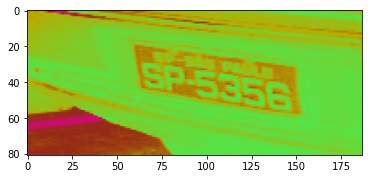

In [ ]:
subimage1path = "/content/subimages_187_81_40_10_90/orig_0001_187_81_133_160_2.png"

subimg = cv2.imread(subimage1path)
print("subimage shape: ", subimg.shape)

plt.imshow(subimg)
plt.show()

**Now, we tested the functions above work properly we can create the subimages for the entire dataset images.**

In [12]:
train_path_array = ["train1.txt", "train2.txt", "train3.txt"]

trainoutputname = ["train1", "train2", "train3"]

outputFolderPath = "_187_95_40_20_90/"
mask_folder_path = 'plates/'
image_folder_path = 'ycbcrplates/'

print("Statistics")
print()
totalSubImages = 0
totalSubImagesClass2 = 0

i = 0
while i < len(train_path_array):
  #creating the training folder that will contain the subimages
  trainoutputFolderPath = trainoutputname[i] + outputFolderPath
  os.mkdir(trainoutputFolderPath)

  f = open(train_path_array[i], "r")
  for imgname in f:
    if len(imgname) > 0:
      imgname = imgname.replace("./plates/", "")
      imgname = imgname.replace(" ", "")
      numberSubimagesClass2, numberSubimagesFromImage = createSubimagesFromTrainingImage(w, h, dx, dy, threshold, imgname.strip(), image_folder_path, mask_folder_path, trainoutputFolderPath)
      totalSubImages += numberSubimagesFromImage
      totalSubImagesClass2 += numberSubimagesClass2
  
  print(trainoutputname[i])
  print("Total number of subimages: ", totalSubImages)
  print("Total number of class 2 subimages: ", totalSubImagesClass2)
  totalSubImages = 0
  totalSubImagesClass2 = 0
  
  i += 1

Statistics

train1
Total number of subimages:  4000
Total number of class 2 subimages:  791
train2
Total number of subimages:  4000
Total number of class 2 subimages:  791
train3
Total number of subimages:  4000
Total number of class 2 subimages:  787
time: 18.5 s


**Creating the test set subimages**

In [13]:
train_path_array = ["test1.txt", "test2.txt", "test3.txt"]

trainoutputname = ["test1", "test2", "test3"]

outputFolderPath = "_187_95_40_20_90/"
mask_folder_path = 'plates/'
image_folder_path = 'ycbcrplates/'

print("Statistics")
print()
totalSubImages = 0
totalSubImagesClass2 = 0

i = 0
while i < len(train_path_array):
  #creating the training folder that will contain the subimages
  trainoutputFolderPath = trainoutputname[i] + outputFolderPath
  os.mkdir(trainoutputFolderPath)

  f = open(train_path_array[i], "r")
  for imgname in f:
    if len(imgname) > 0:
      imgname = imgname.replace("./plates/", "")
      imgname = imgname.replace(" ", "")
      numberSubimagesClass2, numberSubimagesFromImage = createSubimagesFromTrainingImage(w, h, dx, dy, threshold, imgname.strip(), image_folder_path, mask_folder_path, trainoutputFolderPath)
      totalSubImages += numberSubimagesFromImage
      totalSubImagesClass2 += numberSubimagesClass2
  
  print(trainoutputname[i])
  print("Total number of subimages: ", totalSubImages)
  print("Total number of class 2 subimages: ", totalSubImagesClass2)
  totalSubImages = 0
  totalSubImagesClass2 = 0
  
  i += 1

Statistics

test1
Total number of subimages:  4000
Total number of class 2 subimages:  771
test2
Total number of subimages:  4000
Total number of class 2 subimages:  771
test3
Total number of subimages:  4000
Total number of class 2 subimages:  775
time: 15.3 s


In [ ]:
subImagesFolderPath = "/content/subimages_187_81_40_10_90/"
mask_folder_path = '/content/plates/'
image_folder_path = '/content/ycbcrplates/'

print("Statistics")
print()
totalSubImages = 0
totalSubImagesClass2 = 0

for imgname in os.listdir(image_folder_path):
  if "orig" in imgname:
    numberSubimagesClass2, numberSubimagesFromImage = createSubimagesFromTrainingImage(w, h, dx, dy, threshold, imgname, image_folder_path, mask_folder_path, subImagesFolderPath)
    totalSubImages += numberSubimagesFromImage
    totalSubImagesClass2 += numberSubimagesClass2

print("Total number of subimages: ", totalSubImages)
print("Total number of class 2 subimages: ", totalSubImagesClass2)

Statistics

Total number of subimages:  16000
Total number of class 2 subimages:  2556


We got 16,000 subimages in total, or 80 subimages per original image.

The 2 classes are heavily unbalanced as we can see. In fact, only 2,556 out of 16,000 subimages belong to class 2, the remaining belonging to class 1.

Now, we have all the subimages created from the training sets. We are ready for the next step!

## **Batch Normalization**

Let Ii(p) = (Ii1(p), Ii2(p), Ii3(p)) be the three color values of each pixel p in the image domain DI of an image Iˆ = (D , I ), i = 1, 2, . . . , N , of the training set. Batch normalization consists of transforming each image Iˆ
iIi i
into an image Jˆ = (D , J ) such that iIi
Jij(p) = Iij(p) − μj(p), (1) σj (p)
 1  N
μj(p) = N Iij(p),
i=1
  1  N
σj(p) =  N − 1
j = 1, 2, 3.
For the testing set, you can only normalize the images by using the parameters μ(p) = (μ1 (p), μ2 (p), μ3 (p))
and σ(p) = (σ1(p),σ2(p),σ3(p)) learned for each pixel p in the training set. Evaluate your results with and without batch normalization.

In [14]:
#given a folder path with a set of images, function that returns the mean and standard deviation
#of the entire set for batch normalization
def returnBatchNormMeanAndStandarDeviationTensors(folderPath):
  meanTensor = np.array([])
  standardDeviationTensor = np.array([])

  subimagesCount = 0
  for subimagename in os.listdir(folderPath):
    subimage = cv2.imread(folderPath + "/" + subimagename)
    if meanTensor.size == 0:
      meanTensor = subimage
    else:  
      meanTensor += subimage
    subimagesCount += 1
  meanTensor = meanTensor / subimagesCount

  for subimagename in os.listdir(folderPath):
    subimage = cv2.imread(folderPath + "/" + subimagename)
    if standardDeviationTensor.size == 0:
      standardDeviationTensor = (subimage - meanTensor)**2
    else:
      standardDeviationTensor += (subimage - meanTensor)**2
  
  standardDeviationTensor = (standardDeviationTensor / (subimagesCount - 1))**0.5

  return [meanTensor, standardDeviationTensor]

#Normalize the images with Batch Norm inside a specific folder
def normalizeSubimageWithBN(meanTensor, standardDeviationTensor, subimage):
  if 0 in standardDeviationTensor:
    print("Error: standard deviation tensor contains null value")
    return -1
  return (subimage - meanTensor) / standardDeviationTensor

time: 60 ms


In [ ]:
subimagesMeanTensor, subimagesSDTensor = returnBatchNormMeanAndStandarDeviationTensors("/content/train3_187_81_40_10_90")

if 0 in subimagesSDTensor:
  print("There is a null value in the standard deviation tensor")
else:
  print("All values inside the standard deviation tensor are strictly positive")

All values inside the standard deviation tensor are strictly positive


Now, we implemented the Batch Normalization and we made sure no zero value is contained in the standard deviation tensor. 

## **Random kernels**

We must create b random kernels with origin at the central pixel and sizes w × h, w ≪ W and h ≪ H , whose coefficients c(q) = (c1(q), c2(q), c3(q)) (3 bands each), for each pixel q of the adjacency set A(p) with origin p, are random numbers. You should verify and discuss the differences of forcing and not forcing the coefficient vector of each kernel (i.e., the concatenation of all c(q)) to have the mean value of its elements equal to zero and norm equal to one.

In [15]:
#creates b random kernels
#coefficients inside the kernels could be normalized or not
def returnRandombKernels(nkernels, width, height, nbands, normalized = True):
  # we create n kernels randomly without normalization
  if normalized == False:
    
    #return [torch.randn(height, width, nbands) for i in range(0, nkernels)]
    return [np.random.rand(height, width, nbands) for i in range(0, nkernels)]
  
  # we create n kernels randomly then normalize each one of them
  nkernelsArray = [np.random.rand(height, width, nbands) for i in range(0, nkernels)]
  #nkernelsArray = [torch.randn(height, width, nbands) for i in range(0, nkernels)]
  
  i = 0
  while i < nkernels:
      #substracting the mean
      kernelMean = np.sum(nkernelsArray[i]) / (height*width*nbands)
      nkernelsArray[i] = nkernelsArray[i] - kernelMean

      #normalizing the kernel
      kernelnorm = np.sum(nkernelsArray[i]**2)/(height*width*nbands)
      kernelnorm = kernelnorm**0.5
      nkernelsArray[i] = nkernelsArray[i] / kernelnorm
      
      i += 1

  return nkernelsArray

time: 31.5 ms


We test with one example to check we get a kernel properly normalized with mean equal to 0 and norm equal to 1.

In [ ]:
bKernels = np.array(returnRandombKernels(1, 3, 3, 3, True))

meankernel = np.sum(bKernels[0]) / (2*4*3)

norm = np.sum(bKernels[0]**2) / (2*4*3)
norm = norm**0.5

print("mean ", meankernel)
print("norm ", norm)
print(bKernels[0])

mean  3.4463173056072566e-16
norm  1.0606601717798212
[[[-0.0792097   1.84478187 -1.2671353 ]
  [ 0.35854882 -0.98370096 -0.95963122]
  [-0.74327255 -1.44796954 -0.22123495]]

 [[ 0.10143208 -0.84638992  1.34070112]
  [-0.86968997  0.4446246  -1.22737078]
  [-0.01064509 -1.35354779  1.22585608]]

 [[-0.93798125  1.16661126 -0.97831601]
  [ 1.27504358  0.88991354  0.81117963]
  [ 0.7549008   1.42210674  0.29039493]]]


We get the results as expected. Now, we can implement the convolution.

## **Convolution with the kernel bank**

The convolution with the created kernel bank will output images Cˆi = (DI,Ci) with b bands each, such that
(2)
(Iij(p) − μj(p))2, (3)
Ci(p) =   ⟨Ji(q), c(q)⟩.

In [16]:
def returnConvolution(image, kernel):
  kwidth = kernel.shape[1]
  kheight = kernel.shape[0]
  imagewidth = image.shape[1]
  imageheight = image.shape[0]

  imagepaddedwidth = imagewidth + 2*(kwidth // 2)
  imagepaddedheight = imageheight + 2*(kheight // 2)

  imagepadded = np.zeros((imagepaddedheight, imagepaddedwidth, image.shape[2]))

  imagepadded[kheight // 2: -1*(kheight // 2), kwidth // 2:-1*(kwidth // 2), :] = image[:,:,:].copy()

  convo = np.zeros((image.shape[0], image.shape[1]))

  for y in range(image.shape[0]):
    for x in range(image.shape[1]):
      convo[y,x] = (imagepadded[ y : y + kheight, x: x + kwidth, :] * kernel).sum()
  
  return convo

#create convoluted image with b bands
def returnBbandsConvoImage(image, nkernelsArray):
  bBandsConvoImage = np.zeros((image.shape[0], image.shape[1], len(nkernelsArray)))
  for index, kernel in enumerate(nkernelsArray):
    bBandsConvoImage[:,:,index] = returnConvolution(image, kernel)
  return bBandsConvoImage

time: 13.4 ms


In [ ]:
bKernels = np.array(returnRandombKernels(10, 3, 5, 3, True))

test_image_path = "/content/plates/orig_0048.png"

#Import image
subimage = cv2.imread(test_image_path)

subimageconvoluted = returnConvolution(subimage, bKernels[0])

print("Convolution shape ", subimageconvoluted.shape)

Convolution shape  (240, 352)


In [ ]:
bBandsImageresult = returnBbandsConvoImage(subimage, bKernels)

print("shape ",bBandsImageresult.shape )

shape  (240, 352, 10)


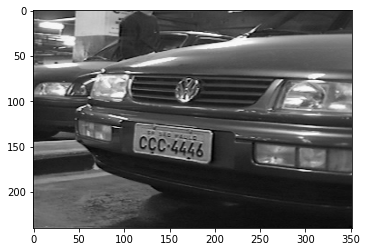

In [ ]:
plt.imshow(subimage)
plt.show()

## **ReLU**

Given the definition of the ReLU function, we implemented the function as follows.

In [17]:
def reLU(image):
  image[image < 0] = 0
  return image

time: 978 µs


## **Model performance functions** 

In this section, we define two scores to evaluate the performance of the model on the training set. 

The first score is the percentage of pixels activated in the plate region of the subimage, over the total number of pixels included inside the plate region in the subimage.

The second score, similar to the first one, is the percentage of deactivated pixels, laying outside the plate region, over the total number of pixels outside the plate region in the subimage.

The higher the two scores, the better the model performance. Since our focus is to build a model that aim to activate as many pixels inside the plate region as possible, the first score is the most important metric.

In [25]:
def computeScoresPerKernel(resultsDf):
  nkernelsarray = resultsDf.kernelID.unique()
  pixelsActivatedScoresArray = []
  outsidePlateDeactivatedPixelsScoresArray = []
  kernelIDArray = []

  for kernelID in nkernelsarray: 
    kernelPlatePixelsActivatedDf = resultsDf[(resultsDf.kernelID == kernelID ) & (resultsDf.percentagePlatePixelsActivated > -1)].copy()
    kernelOutsidePlateDeactivatedDf = resultsDf[resultsDf.kernelID == kernelID ].copy()
    averageOutsidePixelsDeactivated = kernelOutsidePlateDeactivatedDf.percentageDeactivatedPixelsOutsidePlate.mean()
    averagePlatePixelsActivated = 0
    if kernelPlatePixelsActivatedDf.percentagePlatePixelsActivated.count() > 0:
      averagePlatePixelsActivated = kernelPlatePixelsActivatedDf.percentagePlatePixelsActivated.mean()
    pixelsActivatedScoresArray.append( 100*averagePlatePixelsActivated)
    outsidePlateDeactivatedPixelsScoresArray.append(100*(1- averageOutsidePixelsDeactivated))
    kernelIDArray.append("kernel_" + str(kernelID))
  
  return [kernelIDArray, pixelsActivatedScoresArray, outsidePlateDeactivatedPixelsScoresArray]

#plots the two scores to view results per kernel
def plotScores(modelScoresArray):

  fig, ax = plt.subplots()
  ax.scatter(modelScoresArray[1], modelScoresArray[2])

  plt.title("Average scores per kernel")
  plt.xlabel("% activated pixels inside plate region")
  plt.ylabel("% deactivated pixels outside plate region")

  for i, txt in enumerate(modelScoresArray[0]):
      ax.annotate(txt, (modelScoresArray[1][i], modelScoresArray[2][i]))

time: 23.9 ms


In [19]:
def returnScores(subimage, submask):
  submaskOutsidePlate = submask[:, :, 0].copy() 
  submaskInsidePlate = submask[:, :, 0].copy()

  submaskOutsidePlate[submaskOutsidePlate > 0] = 2 #inside plate is equal to 2
  submaskOutsidePlate[submaskOutsidePlate == 0] = 1 #outside plate is equal to 1
  submaskOutsidePlate[submaskOutsidePlate == 2] = 0 #inside plate is equal to 0

  submaskInsidePlate[submaskInsidePlate > 0] = 1

  subimagecopy = subimage.copy()
  subimagecopy[subimagecopy > 0] = 1
  
  nPlatePixels = np.sum(submaskInsidePlate)
  nActivatedPlatePixels = np.sum(subimagecopy*submaskInsidePlate)

  nDeactivatedPixelsOutsidePlate = np.sum(subimagecopy*submaskOutsidePlate)

  percentagePlatePixelsActivated = -1
  if nPlatePixels > 0:
    percentagePlatePixelsActivated = nActivatedPlatePixels/nPlatePixels
  
  width = submask.shape[1]
  height = submask.shape[0]

  percentageDeactivatedPixelsOutsidePlate = nDeactivatedPixelsOutsidePlate/(width * height - nPlatePixels) 

  return [percentagePlatePixelsActivated, percentageDeactivatedPixelsOutsidePlate]

#Returns the percentage of activated pixels over the total number of pixels that figure 
#inside the plate region in the subimage
def returnPercentageActivatedPixelsInPlateRegion(subimage, submask):
  width = submask.shape[1]
  height = submask.shape[0]

  nPlatePixels = 0
  nActivatedPlatePixels = 0
  nDeactivatedPixelsOutsidePlate = 0
  
  i = 0
  while i < height:
    j = 0
    while j < width:
      #pixel value != 0 => inside plate region
      if submask[i][j][0] != 0:
        nPlatePixels += 1
        
        #pixel was activated 
        if subimage[i][j] > 0:
          nActivatedPlatePixels += 1
      
      #pixel value = 0 => outside plate region
      else:
        #pixel was deactivated
        if subimage[i][j] == 0:
          nDeactivatedPixelsOutsidePlate += 1
      
      j += 1
    i += 1

  percentagePlatePixelsActivated = -1
  if nPlatePixels > 0:
    percentagePlatePixelsActivated = nActivatedPlatePixels/nPlatePixels
  
  percentageDeactivatedPixelsOutsidePlate = nDeactivatedPixelsOutsidePlate/(width * height - nPlatePixels)

  return [percentagePlatePixelsActivated, percentageDeactivatedPixelsOutsidePlate]

time: 36.1 ms


In [ ]:
subimg = cv2.imread("/content/orig_0002.png")[100:150,100:250,:]
maskimg = cv2.imread("/content/mask_0002.png")[100:150,100:250,:]

percentagePlatePixelsActivated, percentageDeactivatedPixelsOutsidePlate = returnPercentageActivatedPixelsInPlateRegion(subimg, maskimg)

1.0 - 0.00020610057708161583


## **Selecting the kernels from the kernel bank**

In order to select the best kernels, we run the function for computing the performance of each kernel and then from there select the best kernels from the kernel bank.

After that, we apply those kernels to the test set for a final evaluation of the model.

## **Main task**

In this section, we analyze the output of each kernel using the training set, and verify for several choices of the above parameters which kernels best enhance the characters of the plate, while reducing the regions of false positives in background patches. 

We will compare those kernels with a simple Sobel filter to enhance vertical edges. We will then select the best kernels manually and apply them on the testing set. The report will present a discussion, results, and conclusions from this experiment.

## **Model configurations**

In this project, we test various configurations of the model:

1. we test the effect of batch normalization
2. we test for sizes of the kernel. We try: 3x3, 5x5, and 3x5
3. we test whether we normalize the kernel

So, we have the following configurations:

1. BN + size of kernel + kernel normalized
2. BN + size of kernel + kernel without normalization
3. no BN + size of kernel + kernel normalized

the third possibility: no BN + size of kernel + kenel without normalization won't be experimented, since we will end up with only positive values for all the pixels after the activation function ReLU. The ending result would be that the model activated every pixel in the subimages. For that reason, we discard this configuration from the study.

In total, we test 9 variations of the model.



In [ ]:
def saveTensor(tensor, tensorFullpath):
  tensor = tensor.reshape(tensor.shape[0], -1)
  print(tensor.shape)
  #tensor.to_csv(tensorFullpath)

In [ ]:
saveTensor(bKernels[0], "tensortest.csv")
bKernels[0]

## **Main**

**Nomenclature functions**

In [20]:
def returnSubimageDimensionsCenterCoordinates(imagename):
  imagename = imagename.replace(".png", "")
  elementsArray = imagename.split("_")
  imageID = elementsArray[1]
  width = int(elementsArray[2])
  height = int(elementsArray[3])
  xcenter = int(elementsArray[4])
  ycenter = int(elementsArray[5])
  imageclass = int(elementsArray[6])
  return [imageID, width, height, xcenter, ycenter, imageclass]

time: 5.4 ms


In [21]:
def launchModelEvaluation(trainingsetName, trainFolder, maskFolderPath, modelOptions):

  meanTensor = np.array([])
  standardDeviationTensor = np.array([])

  kernelresultsDF = pd.DataFrame(columns = ["TrainingSet", 'Imagename', "kernelID", 'percentagePlatePixelsActivated', 'percentageDeactivatedPixelsOutsidePlate'])

  if modelOptions["batchnormalization"] == True:
    meanTensor, standardDeviationTensor = returnBatchNormMeanAndStandarDeviationTensors(trainFolder)
    
  bKernels = np.array(returnRandombKernels(modelOptions["kernelBank"]["nkernels"], modelOptions["kernelBank"]["width"], modelOptions["kernelBank"]["height"], modelOptions["kernelBank"]["nbands"], modelOptions["kernelBank"]["normalized"]))  

  imageprocessed = 0

  for imagename in os.listdir(trainFolder):
    image = cv2.imread(trainFolder + imagename)
    
    #Batch Normalization if set to True
    if modelOptions["batchnormalization"] == True:
      image = normalizeSubimageWithBN(meanTensor, standardDeviationTensor, image)

    #Convolution with kernel bank
    bBandsConvoImage = returnBbandsConvoImage(image, bKernels)
    
    #ReLU
    bBandsImages = reLU(bBandsConvoImage)

    imageID, width, height, xcenter, ycenter, imageclass = returnSubimageDimensionsCenterCoordinates(imagename)
    imagemask = cv2.imread(maskFolderPath + "mask_" + imageID + ".png", 1)
    submask = returnSubimageWith(width, height, xcenter, ycenter, imagemask)

    #getting model scores on image
    index = 0
    while index < bBandsImages.shape[2]:
      #percentagePlatePixelsActivated, percentageDeactivatedPixelsOutsidePlate = returnPercentageActivatedPixelsInPlateRegion(bBandsImages[:,:,index], submask)
      percentagePlatePixelsActivated, percentageDeactivatedPixelsOutsidePlate = returnScores(bBandsImages[:,:,index], submask)
      kernelresultsDF = kernelresultsDF.append({"TrainingSet": trainingsetName,'Imagename' : imagename, 'kernelID' : index, 'percentagePlatePixelsActivated' : percentagePlatePixelsActivated, "percentageDeactivatedPixelsOutsidePlate": percentageDeactivatedPixelsOutsidePlate},  
                ignore_index = True)

      index += 1

    imageprocessed +=1
    if imageprocessed % 2000 == 0:
      print("Number of images processed ", imageprocessed)

  return [bKernels, kernelresultsDF]

time: 30.7 ms


In [ ]:
trainsetName = "Trainset1"
trainFolderPath = "/content/train1_187_95_40_20_90/"
maskFolder = "plates/"

modelOptionsObj = {"batchnormalization": True, "kernelBank":{"nkernels": 10, "width": 3, "height": 3, "nbands": 3, "normalized":True }}

trainset1bKernelsUsed, trainset1resultsDataFrame = launchModelEvaluation(trainsetName, trainFolderPath, maskFolder, modelOptionsObj)

In [24]:
def launchModelTestEvaluation(trainingsetName, trainFolder, maskFolderPath, modelOptions, meanTensor, standardDeviationTensor, bKernels, kernelIDsarray):

  kernelresultsDF = pd.DataFrame(columns = ["TestSet", 'Imagename', "kernelID", 'percentagePlatePixelsActivated', 'percentageDeactivatedPixelsOutsidePlate'])

  imageprocessed = 0

  for imagename in os.listdir(trainFolder):
    image = cv2.imread(trainFolder + imagename)
    
    #Batch Normalization if set to True
    if modelOptions["batchnormalization"] == True:
      image = normalizeSubimageWithBN(meanTensor, standardDeviationTensor, image)

    #Convolution with kernel bank
    bBandsConvoImage = returnBbandsConvoImage(image, bKernels)
    
    #ReLU
    bBandsImages = reLU(bBandsConvoImage)

    imageID, width, height, xcenter, ycenter, imageclass = returnSubimageDimensionsCenterCoordinates(imagename)
    imagemask = cv2.imread(maskFolderPath + "mask_" + imageID + ".png", 1)
    submask = returnSubimageWith(width, height, xcenter, ycenter, imagemask)

    #getting model scores on image
    index = 0
    while index < bBandsImages.shape[2]:
      #percentagePlatePixelsActivated, percentageDeactivatedPixelsOutsidePlate = returnPercentageActivatedPixelsInPlateRegion(bBandsImages[:,:,index], submask)
      percentagePlatePixelsActivated, percentageDeactivatedPixelsOutsidePlate = returnScores(bBandsImages[:,:,index], submask)
      kernelresultsDF = kernelresultsDF.append({"TestSet": trainingsetName,'Imagename' : imagename, 'kernelID' : kernelIDsarray[index], 'percentagePlatePixelsActivated' : percentagePlatePixelsActivated, "percentageDeactivatedPixelsOutsidePlate": percentageDeactivatedPixelsOutsidePlate},  
                ignore_index = True)

      index += 1

    imageprocessed +=1
    if imageprocessed % 2000 == 0:
      print("Number of images processed ", imageprocessed)

  return kernelresultsDF

time: 18.8 ms


In [ ]:
modelOptionsObj1 = {"batchnormalization": True, "kernelBank":{"nkernels": 10, "width": 3, "height": 3, "nbands": 3, "normalized":True }}
modelOptionsObj2 = {"batchnormalization": False, "kernelBank":{"nkernels": 10, "width": 3, "height": 3, "nbands": 3, "normalized":True }}
modelOptionsObj3 = {"batchnormalization": True, "kernelBank":{"nkernels": 10, "width": 3, "height": 3, "nbands": 3, "normalized":False }}
modelOptionsObj4 = {"batchnormalization": True, "kernelBank":{"nkernels": 10, "width": 5, "height": 5, "nbands": 3, "normalized":True }}
modelOptionsObj5 = {"batchnormalization": True, "kernelBank":{"nkernels": 10, "width": 7, "height": 3, "nbands": 3, "normalized":True }}

#modelOptionsObjarray = [modelOptionsObj1, modelOptionsObj2, modelOptionsObj3, modelOptionsObj4, modelOptionsObj5]

modelOptionsObjarray = [ modelOptionsObj1]

#trainsetNamearray = ["Trainset1", "Trainset2", "Trainset3"]
#testsetNamearray = ["Testset1", "Testset2", "Testset3"]

trainsetNamearray = ["Trainset1"]
testsetNamearray = ["Testset1"]


trainFolderPatharray = ["/content/train1_187_95_40_20_90/", "/content/train2_187_95_40_20_90/", "/content/train3_187_95_40_20_90/"]
testFolderPatharray = ["/content/test1_187_95_40_20_90/", "/content/test2_187_95_40_20_90/", "/content/test3_187_95_40_20_90/"]

maskFolder = "plates/"

j = 0
modelprename = "model"

kernelsSet = []

print("starting...")
print()

for modelOptionsObj in modelOptionsObjarray:
  i = 0
  j += 1

  while i < len(trainsetNamearray):
    
    trainsetName = trainsetNamearray[i]
    trainFolderPath = trainFolderPatharray[i]

    trainsetbKernelsUsed, trainsetresultsDataFrame = launchModelEvaluation(trainsetName, trainFolderPath, maskFolder, modelOptionsObj)

    kernelsSet.append(trainsetbKernelsUsed)

    modelname = modelprename + str(j) + "_" + trainsetName + "results.csv"
    trainsetresultsDataFrame.to_csv(modelname)
    files.download(modelname)

    #TEST part
    meanTens = np.array([])
    standardDeviationTens = np.array([])
    if modelOptionsObj["batchnormalization"] == True:
      meanTens, standardDeviationTens = returnBatchNormMeanAndStandarDeviationTensors(trainFolderPath)

    testsetName = testsetNamearray[i]
    testFolderPath= testFolderPatharray[i]

    #testResultDataframe = launchModelTestEvaluation(testsetName, testFolderPath, maskFolder, modelOptionsObj, meanTens, standardDeviationTens, trainsetbKernelsUsed)
    #modelname = modelprename + str(j) + "_" + testsetName + "results.csv"
    #testResultDataframe.to_csv(modelname)
    #files.download(modelname)

    i += 1
  
  print("Model ", j)


print("Model 1 kernels")

i = 0
for kernel in trainsetbKernelsUsed:
  print("kernel ", i)
  print(kernel)
  print()
  i+=1

starting...

Number of images processed  500
Number of images processed  1000
Number of images processed  1500
Number of images processed  2000
Number of images processed  2500
Number of images processed  3000
Number of images processed  3500
Number of images processed  4000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model  1
Model 1 kernels
kernel  0
[[[-0.92813504 -1.60193959  1.06812273]
  [ 0.53740597  1.20832704  0.10121898]
  [-0.00795904 -1.07644709 -0.60571016]]

 [[-1.20078185  1.87117512 -1.20670207]
  [ 0.00646715 -0.44198345 -0.06672964]
  [-1.11525659  0.89730314 -0.23860353]]

 [[ 1.69483942  0.42247465  0.73686667]
  [ 0.25940569 -0.61876108  1.84790727]
  [-1.72013075  0.02490962  0.15271644]]]

kernel  1
[[[ 1.40143075  0.26086177  0.70453523]
  [ 1.11352672  0.99520095 -0.59724033]
  [-0.99993076 -0.96372664  1.51413677]]

 [[ 0.41441632  0.9438536  -0.96030802]
  [ 1.4260765  -0.10539928 -0.33655447]
  [-0.56743854 -1.71632193  0.74666126]]

 [[-1.25878451  0.95582192  1.0959302 ]
  [-0.60137535 -1.76696204 -0.83904979]
  [-1.26222839 -0.05719172  0.46005978]]]

kernel  2
[[[-0.54755466 -0.70086094  1.31006344]
  [ 1.32232808 -0.84035002 -0.39825457]
  [-0.73231378  0.27904765  0.86297448]]

 [[-0.68165261  1.11877664 -0.94556071]
  [ 1.22776378  0.41435128  0.40142464]
  [-0.236

In [ ]:
testResultDataframe

,TestSet,Imagename,kernelID,percentagePlatePixelsActivated,percentageDeactivatedPixelsOutsidePlate
0,Testset1,orig_0191_187_95_173_47_1.png,0,-1,0.287194
1,Testset1,orig_0191_187_95_173_47_1.png,1,-1,0.250999
2,Testset1,orig_0191_187_95_173_47_1.png,2,-1,0.296032
3,Testset1,orig_0191_187_95_173_47_1.png,3,-1,0.727385
4,Testset1,orig_0191_187_95_173_47_1.png,4,-1,0.336842
...,...,...,...,...,...
39995,Testset1,orig_0042_187_95_173_167_2.png,5,0.713112,0.190234
39996,Testset1,orig_0042_187_95_173_167_2.png,6,0.799061,0.244079
39997,Testset1,orig_0042_187_95_173_167_2.png,7,0.542388,0.347938
39998,Testset1,orig_0042_187_95_173_167_2.png,8,0.883837,0.566732


time: 62.2 ms


In [ ]:
print("Model 5 kernels")

i = 0
for kernel in trainsetbKernelsUsed:
  print("kernel ", i)
  print(kernel)
  print()
  i+=1

Model 5 kernels
kernel  0
[[[ 0.30886987 -1.31732794 -0.20694034]
  [-1.69193448 -0.04230101  0.14903301]
  [ 0.39944508  1.38124175  0.8347378 ]
  [-1.08333281 -0.85404796 -0.81628067]
  [ 0.70366941 -0.61597587  1.51342804]
  [-0.55667697 -0.80799575  1.10334111]
  [ 0.7025113   0.3217316   0.39508336]]

 [[ 1.04771136 -1.64670965  0.58049864]
  [ 1.16576932 -0.16886328  1.33608575]
  [ 0.4324186  -0.35129701 -0.74070564]
  [-1.07142803 -0.06666211  1.09548993]
  [ 1.11414251 -1.0775307   0.21772763]
  [ 1.42016174  0.87858904  1.38037471]
  [-0.86498192  0.3996987  -1.62790918]]

 [[ 1.42416077 -1.38694804 -0.18012916]
  [ 0.59753289 -0.09752373 -1.12186449]
  [-1.05359352  1.26754769  1.40332555]
  [-0.07422961  0.95600934 -1.15778851]
  [-1.20134805  0.927207   -0.82965458]
  [-1.56677303 -0.97091651 -1.83477469]
  [-0.62828936  1.53205634  0.72313476]]]

kernel  1
[[[ 1.17168187  0.10608278 -1.02660016]
  [-0.84385161 -0.9252194   0.8843524 ]
  [ 0.69118536 -0.11950509  1.1474003

In [ ]:
modelOptionsObj1 = {"batchnormalization": True, "kernelBank":{"nkernels": 10, "width": 3, "height": 3, "nbands": 3, "normalized":True }}
modelOptionsObj2 = {"batchnormalization": False, "kernelBank":{"nkernels": 10, "width": 3, "height": 3, "nbands": 3, "normalized":True }}
modelOptionsObj3 = {"batchnormalization": True, "kernelBank":{"nkernels": 10, "width": 3, "height": 3, "nbands": 3, "normalized":False }}
modelOptionsObj4 = {"batchnormalization": True, "kernelBank":{"nkernels": 10, "width": 5, "height": 5, "nbands": 3, "normalized":True }}
modelOptionsObj5 = {"batchnormalization": True, "kernelBank":{"nkernels": 10, "width": 7, "height": 3, "nbands": 3, "normalized":True }}

#modelOptionsObjarray = [modelOptionsObj1, modelOptionsObj2, modelOptionsObj3, modelOptionsObj4, modelOptionsObj5]

modelOptionsObjarray = [ modelOptionsObj1]

#trainsetNamearray = ["Trainset1", "Trainset2", "Trainset3"]
#testsetNamearray = ["Testset1", "Testset2", "Testset3"]

trainsetNamearray = [ "Trainset3"]
testsetNamearray = ["Testset3"]


trainFolderPatharray = ["/content/train1_187_95_40_20_90/", "/content/train2_187_95_40_20_90/", "/content/train3_187_95_40_20_90/"]
testFolderPatharray = ["/content/test1_187_95_40_20_90/", "/content/test2_187_95_40_20_90/", "/content/test3_187_95_40_20_90/"]

maskFolder = "plates/"

j = 0
modelprename = "model"

kernelsSet = []

print("starting...")
print()

for modelOptionsObj in modelOptionsObjarray:
  i = 0
  j += 1

  while i < len(trainsetNamearray):
    
    trainsetName = trainsetNamearray[i]
    trainFolderPath = trainFolderPatharray[i]

    trainsetbKernelsUsed, trainsetresultsDataFrame = launchModelEvaluation(trainsetName, trainFolderPath, maskFolder, modelOptionsObj)

    kernelsSet.append(trainsetbKernelsUsed)

    modelname = modelprename + str(j) + "_" + trainsetName + "results.csv"
    trainsetresultsDataFrame.to_csv(modelname)
    
    #TEST part
    meanTens = np.array([])
    standardDeviationTens = np.array([])
    if modelOptionsObj["batchnormalization"] == True:
      meanTens, standardDeviationTens = returnBatchNormMeanAndStandarDeviationTensors(trainFolderPath)

    testsetName = testsetNamearray[i]
    testFolderPath= testFolderPatharray[i]

    #testResultDataframe = launchModelTestEvaluation(testsetName, testFolderPath, maskFolder, modelOptionsObj, meanTens, standardDeviationTens, trainsetbKernelsUsed)
    #modelname = modelprename + str(j) + "_" + testsetName + "results.csv"
    #testResultDataframe.to_csv(modelname)

    i += 1
  
  print("Model ", j)


print("Model 1 kernels")

i = 0
for kernel in trainsetbKernelsUsed:
  print("kernel ", i)
  print(kernel)
  print()
  i+=1

starting...

Number of images processed  500
Number of images processed  1000
Number of images processed  1500
Number of images processed  2000
Number of images processed  2500
Number of images processed  3000
Number of images processed  3500
Number of images processed  4000
Model  1
Model 1 kernels
kernel  0
[[[ 1.37783781 -0.51767582 -0.8061851 ]
  [ 1.57259461 -0.18737986 -0.29962281]
  [-1.76138367  1.31852815 -0.98429667]]

 [[-0.41262925  0.88951211  1.44023894]
  [-0.28569755  0.5427874   1.12589145]
  [-1.01465596  1.04878033  0.84033207]]

 [[-0.5468286  -1.32932188 -0.67498102]
  [ 0.6103199   0.70645167  0.72414744]
  [-1.72501703 -0.786482   -0.86526467]]]

kernel  1
[[[-0.98571143  0.15590174  1.56445559]
  [-1.56863626 -1.58387202 -0.21210243]
  [ 1.09503841  0.96054774  1.19110866]]

 [[-1.43024488  0.00903017 -1.88458497]
  [ 1.53008677 -0.09330062  0.36177742]
  [ 0.78400903 -0.5313749   0.63604125]]

 [[-0.22107432  0.78596806 -1.62810256]
  [ 0.40215388 -0.79158312  

In [ ]:
print("Model 1, train set 2")
print()
i = 0
for kernel in trainsetbKernelsUsed:
  print("kernel ", i)
  print(kernel)
  print()
  i+=1

Model 1, train set 2

kernel  0
[[[-1.36588669 -1.10065224  0.06874304]
  [-1.2807445  -1.08718948 -0.46644976]
  [ 0.52316689 -1.37879751 -0.68212607]]

 [[ 1.64915028 -0.82536934  0.55409325]
  [ 1.5534529   1.38022061 -0.39406679]
  [ 0.19621662 -1.14010866 -0.78128466]]

 [[-0.91775772 -0.174628   -0.29679572]
  [ 0.71662914  1.22087258  0.50005836]
  [ 0.49957221  1.67910435  1.35057689]]]

kernel  1
[[[-2.53261972e-02  1.06900295e+00 -3.15528436e-01]
  [-2.09778165e-01  3.23429651e-01 -7.61860978e-01]
  [ 9.95993570e-01  5.81937959e-01  1.45694334e+00]]

 [[-1.93647408e+00  1.93495666e-01  6.57124791e-01]
  [ 2.67311706e-01 -2.36015384e+00  1.69005993e+00]
  [ 7.25753928e-01  8.92851326e-01 -2.14438317e-03]]

 [[ 9.13618733e-01 -1.20691718e+00 -4.39832165e-01]
  [-5.81892529e-01 -1.08685049e+00  2.43056737e-02]
  [-1.49318045e+00  1.05614272e+00 -4.28033047e-01]]]

kernel  2
[[[ 0.68493452  0.98417931 -0.52584645]
  [-0.25336727  1.67519852 -1.34946391]
  [-0.25893459 -1.7637158 

In [ ]:
scoresarray = computeScoresPerKernel(trainsetresultsDataFrame)

print(scoresarray)

[['kernel_0', 'kernel_1', 'kernel_2', 'kernel_3', 'kernel_4', 'kernel_5', 'kernel_6', 'kernel_7', 'kernel_8', 'kernel_9'], [21.782489874494964, 51.61405351286239, 37.66301288330281, 87.20089506805317, 75.47833884072742, 49.78218503553104, 69.0665913552083, 19.716660333065878, 61.53832709717506, 68.16275324954549], [46.86526641886013, 29.005658898381647, 26.832054118424065, 62.71329857516338, 70.58108400460758, 74.15533494731868, 33.10618611599354, 42.19404055367292, 42.332579532907204, 38.971682993558275]]
time: 103 ms


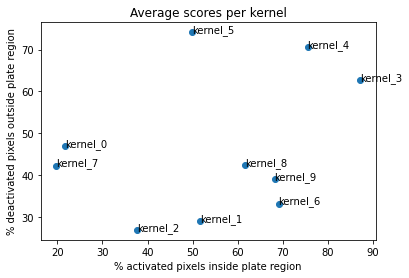

time: 210 ms


In [ ]:
fig, ax = plt.subplots()
ax.scatter(scoresarray[1], scoresarray[2])

plt.title("Average scores per kernel")
plt.xlabel("% activated pixels inside plate region")
plt.ylabel("% deactivated pixels outside plate region")

for i, txt in enumerate(scoresarray[0]):
    ax.annotate(txt, (scoresarray[1][i], scoresarray[2][i]))

## **Evaluating the kernels on the tests set MODEL1**

**Train set 1 , test set 1**

In [ ]:
modelOptionsObjarray = [ modelOptionsObj1]

trainsetNamearray = [ "Trainset1"]
testsetNamearray = ["Testset1"]

trainFolderPatharray = ["/content/train1_187_95_40_20_90/"]
testFolderPatharray = ["/content/test1_187_95_40_20_90/"]

maskFolder = "plates/"

j = 0

modelprename = "model"

print("starting...")
print()

for modelOptionsObj in modelOptionsObjarray:
  i = 0
  j += 1

  while i < len(trainsetNamearray):
    
    trainsetName = trainsetNamearray[i]
    trainFolderPath = trainFolderPatharray[i]

    print("train set name ", trainsetName)
    print("train folder ", trainFolderPath)

    trainsetbKernelsUsed, trainsetresultsDataFrame = launchModelEvaluation(trainsetName, trainFolderPath, maskFolder, modelOptionsObj)

    modelname = modelprename + str(j) + "_" + trainsetName + "results.csv"
    trainsetresultsDataFrame.to_csv(modelname)
    
    k = 0
    for kernel in trainsetbKernelsUsed:
      print("kernel ", k)
      print(kernel)
      print()
      k+=1
    
    i += 1

starting...

train set name  Trainset1
train folder  /content/train1_187_95_40_20_90/


In [ ]:
scoresarray = computeScoresPerKernel(trainsetresultsDataFrame)
plotScores(scoresarray)

In [ ]:

bestTrainsetbKernels = 


testFolderPath = "/content/test1_187_95_40_20_90/"

testsetName = "Testset1"

modelname = "Model1" + str(j) + "_" + testsetName + "results.csv"

meanTens = np.array([])
standardDeviationTens = np.array([])
if modelOptionsObj["batchnormalization"] == True:
  meanTens, standardDeviationTens = returnBatchNormMeanAndStandarDeviationTensors(trainFolderPath)

testResultDataframe = launchModelTestEvaluation(testsetName, testFolderPath, maskFolder, modelOptionsObj, meanTens, standardDeviationTens, bestTrainsetbKernels)

testResultDataframe.to_csv(modelname)

**Train set 2, test set 2**

In [23]:
modelOptionsObj1 = {"batchnormalization": True, "kernelBank":{"nkernels": 10, "width": 3, "height": 3, "nbands": 3, "normalized":True }}
modelOptionsObj2 = {"batchnormalization": False, "kernelBank":{"nkernels": 10, "width": 3, "height": 3, "nbands": 3, "normalized":True }}
modelOptionsObj3 = {"batchnormalization": True, "kernelBank":{"nkernels": 10, "width": 3, "height": 3, "nbands": 3, "normalized":False }}
modelOptionsObj4 = {"batchnormalization": True, "kernelBank":{"nkernels": 10, "width": 5, "height": 5, "nbands": 3, "normalized":True }}
modelOptionsObj5 = {"batchnormalization": True, "kernelBank":{"nkernels": 10, "width": 7, "height": 3, "nbands": 3, "normalized":True }}

modelOptionsObjarray = [ modelOptionsObj1]

trainsetNamearray = [ "Trainset2"]
testsetNamearray = ["Testset2"]

trainFolderPatharray = ["/content/train2_187_95_40_20_90/"]
testFolderPatharray = ["/content/test2_187_95_40_20_90/"]

maskFolder = "plates/"

j = 0

modelprename = "model"

print("starting...")
print()

for modelOptionsObj in modelOptionsObjarray:
  i = 0
  j += 1

  while i < len(trainsetNamearray):
    
    trainsetName = trainsetNamearray[i]
    trainFolderPath = trainFolderPatharray[i]

    print("train set name ", trainsetName)
    print("train folder ", trainFolderPath)

    trainsetbKernelsUsed, trainsetresultsDataFrame = launchModelEvaluation(trainsetName, trainFolderPath, maskFolder, modelOptionsObj)

    modelname = modelprename + str(j) + "_" + trainsetName + "results.csv"
    trainsetresultsDataFrame.to_csv(modelname)

    print("Model 1, train set ", trainsetName)
    print()
    
    k = 0
    for kernel in trainsetbKernelsUsed:
      print("kernel ", k)
      print(kernel)
      print()
      k+=1
    
    i += 1

starting...

train set name  Trainset2
train folder  /content/train2_187_95_40_20_90/
Number of images processed  2000
Number of images processed  4000
Model 1, train set  Trainset2

kernel  0
[[[-1.30644726  0.86350263 -0.56196049]
  [-0.61612914 -1.30520962  0.11838271]
  [-0.00725846  0.87851648 -1.34246691]]

 [[ 0.9870099   0.15819819 -1.73650954]
  [-0.69324433  0.29409335  0.9251609 ]
  [ 0.65436198  1.66169049  0.40419814]]

 [[ 0.09337475  1.27988565 -1.47197439]
  [ 1.36233626  1.35307047 -0.51248519]
  [-1.71492456  0.25626509 -0.02143707]]]

kernel  1
[[[-0.49328776 -0.26022934 -0.07726513]
  [ 0.62305609 -1.18807372  1.30682892]
  [-1.1473942   0.53664294  0.69216054]]

 [[ 0.44217791  1.2554889   0.37654726]
  [-1.66697491 -1.08471196  0.38679629]
  [ 1.59883325  0.66156561  1.24079683]]

 [[ 0.79049535 -1.30516256  1.48954557]
  [-1.74202626 -0.56440704  0.24604363]
  [-0.15567005 -0.41944423 -1.54233193]]]

kernel  2
[[[-1.51412668  0.2331944  -0.80507979]
  [-1.3455603

Scores
[['kernel_0', 'kernel_1', 'kernel_2', 'kernel_3', 'kernel_4', 'kernel_5', 'kernel_6', 'kernel_7', 'kernel_8', 'kernel_9'], [47.50274578608058, 32.44803525669492, 44.44980907511138, 36.83237617143623, 78.85109476671242, 28.875918567504165, 45.79558625093236, 80.06081233003161, 85.25857175146707, 80.07996070926039], [24.935544795840748, 74.30173592361609, 26.7136321164105, 76.62075882098185, 29.50035148150554, 72.48378827363196, 28.002681280431, 58.293104685606714, 48.075004026375666, 50.735300985634744]]


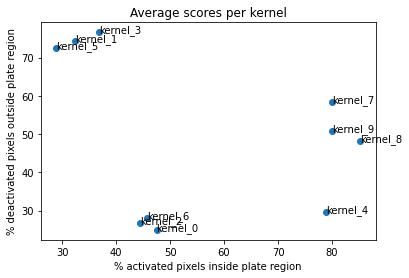

time: 310 ms


In [29]:
scoresarray = computeScoresPerKernel(trainsetresultsDataFrame)
print("Scores")
print(scoresarray)
plotScores(scoresarray)

In [27]:
bestkernels = [7, 8, 9 ]

bestTrainsetbKernels = []
kernelIDarray = []

s = 0
for kernel in trainsetbKernelsUsed:
  if s in bestkernels:
    bestTrainsetbKernels.append(kernel) 
    kernelIDarray.append(s)
  s +=1 


testFolderPath = "/content/test2_187_95_40_20_90/"

testsetName = "Testset2"

modelname = "Model1" + str(j) + "_" + testsetName + "results.csv"

meanTens = np.array([])
standardDeviationTens = np.array([])
if modelOptionsObj["batchnormalization"] == True:
  meanTens, standardDeviationTens = returnBatchNormMeanAndStandarDeviationTensors(trainFolderPath)

testResultDataframe = launchModelTestEvaluation(testsetName, testFolderPath, maskFolder, modelOptionsObj, meanTens, standardDeviationTens, bestTrainsetbKernels, kernelIDarray)

testResultDataframe.to_csv(modelname)

Number of images processed  2000
Number of images processed  4000
time: 20min 42s


Scores 
[['kernel_7', 'kernel_8', 'kernel_9'], [79.8699183742596, 85.10438056672727, 79.76277198220072], [59.33640828926019, 49.07650384878347, 51.58269665508761]]


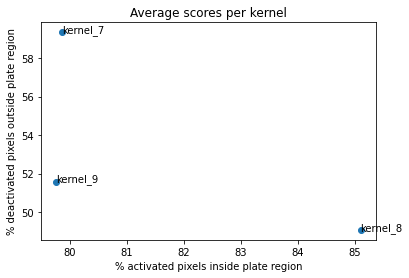

time: 234 ms


In [28]:
scoresarray = computeScoresPerKernel(testResultDataframe)

print("Scores ")
print(scoresarray)
plotScores(scoresarray)

**Train set 3 test set 3**

In [ ]:
modelOptionsObjarray = [ modelOptionsObj1]

trainsetNamearray = [ "Trainset3"]
testsetNamearray = ["Testset3"]

trainFolderPatharray = ["/content/train3_187_95_40_20_90/"]
testFolderPatharray = ["/content/test3_187_95_40_20_90/"]

maskFolder = "plates/"

j = 0

modelprename = "model"

print("starting...")
print()

for modelOptionsObj in modelOptionsObjarray:
  i = 0
  j += 1

  while i < len(trainsetNamearray):
    
    trainsetName = trainsetNamearray[i]
    trainFolderPath = trainFolderPatharray[i]

    print("train set name ", trainsetName)
    print("train folder ", trainFolderPath)

    trainsetbKernelsUsed, trainsetresultsDataFrame = launchModelEvaluation(trainsetName, trainFolderPath, maskFolder, modelOptionsObj)

    modelname = modelprename + str(j) + "_" + trainsetName + "results.csv"
    trainsetresultsDataFrame.to_csv(modelname)

    print("Model 1, train set ", trainsetName)
    print()
    
    k = 0
    for kernel in trainsetbKernelsUsed:
      print("kernel ", k)
      print(kernel)
      print()
      k+=1
    
    i += 1

In [ ]:
scoresarray = computeScoresPerKernel(trainsetresultsDataFrame)
plotScores(scoresarray)

In [ ]:
bestTrainsetbKernels = 


testFolderPath = "/content/test3_187_95_40_20_90/"

testsetName = "Testset3"

modelname = "Model1" + str(j) + "_" + testsetName + "results.csv"

meanTens = np.array([])
standardDeviationTens = np.array([])
if modelOptionsObj["batchnormalization"] == True:
  meanTens, standardDeviationTens = returnBatchNormMeanAndStandarDeviationTensors(trainFolderPath)

testResultDataframe = launchModelTestEvaluation(testsetName, testFolderPath, maskFolder, modelOptionsObj, meanTens, standardDeviationTens, bestTrainsetbKernels)

testResultDataframe.to_csv(modelname)

## **Model 4**

In [30]:
modelOptionsObjarray = [ modelOptionsObj4]

trainsetNamearray = [ "Trainset2"]
testsetNamearray = ["Testset2"]

trainFolderPatharray = ["/content/train2_187_95_40_20_90/"]
testFolderPatharray = ["/content/test2_187_95_40_20_90/"]

maskFolder = "plates/"

j = 3

modelprename = "model"

print("starting...")
print()

for modelOptionsObj in modelOptionsObjarray:
  i = 0
  j += 1

  while i < len(trainsetNamearray):
    
    trainsetName = trainsetNamearray[i]
    trainFolderPath = trainFolderPatharray[i]

    print("train set name ", trainsetName)
    print("train folder ", trainFolderPath)

    trainsetbKernelsUsed, trainsetresultsDataFrame = launchModelEvaluation(trainsetName, trainFolderPath, maskFolder, modelOptionsObj)

    modelname = modelprename + str(j) + "_" + trainsetName + "results.csv"
    trainsetresultsDataFrame.to_csv(modelname)
    
    k = 0
    for kernel in trainsetbKernelsUsed:
      print("kernel ", k)
      print(kernel)
      print()
      k+=1
    
    i += 1

starting...

train set name  Trainset2
train folder  /content/train2_187_95_40_20_90/
Number of images processed  2000
Number of images processed  4000
kernel  0
[[[-0.33219869 -0.04923783 -1.28153341]
  [-1.09666872  0.88689767 -0.04830894]
  [ 1.16169573  1.6803799  -1.04367038]
  [ 0.72491329 -0.48153843 -0.39917967]
  [-1.36914361 -0.37879815  0.5331758 ]]

 [[ 0.96930938 -0.30072957  1.25417012]
  [ 1.39950962 -0.55709997 -1.75521294]
  [-0.86570958 -1.7573655  -1.02930822]
  [-0.81831692  1.18383697  0.76142177]
  [ 1.24446427  0.44251442 -1.62909598]]

 [[ 1.04769653 -0.73011584 -1.73708972]
  [ 0.52646193  1.47555181 -0.85363032]
  [ 1.70578306 -0.00878696 -0.07131618]
  [-0.99710463  0.36045572  1.10210728]
  [ 0.78541285  0.36125622 -0.57073363]]

 [[-0.79601611 -0.26451287 -1.74824125]
  [ 0.92842849  0.48233749 -0.27483093]
  [-1.13689591 -0.78677178 -0.46738357]
  [-1.43558458  1.00956583  0.13379516]
  [ 1.53144332 -0.64281673  0.04440049]]

 [[ 1.17569293  0.0912602  -0.

Scores
[['kernel_0', 'kernel_1', 'kernel_2', 'kernel_3', 'kernel_4', 'kernel_5', 'kernel_6', 'kernel_7', 'kernel_8', 'kernel_9'], [74.02440683672349, 29.356328915426705, 42.60394048044178, 75.90820549582085, 63.52863745997853, 37.61124478258502, 36.30181727141712, 38.91561658802992, 79.17231887373882, 27.836582521483372], [27.970933319218528, 73.52954078810905, 29.121482607935057, 40.3341784325565, 55.79394641751454, 63.59298603937987, 75.41599710184477, 30.14807715656651, 49.33868419829813, 69.80723366851727]]


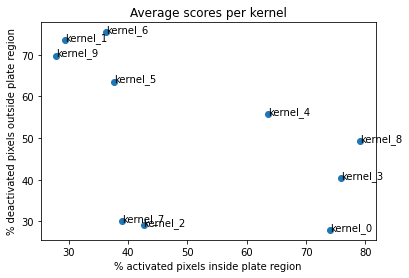

time: 329 ms


In [31]:
scoresarray = computeScoresPerKernel(trainsetresultsDataFrame)
print("Scores")
print(scoresarray)
plotScores(scoresarray)

## **Model 5**

In [32]:
modelOptionsObjarray = [ modelOptionsObj5]

trainsetNamearray = [ "Trainset2"]
testsetNamearray = ["Testset2"]

trainFolderPatharray = ["/content/train2_187_95_40_20_90/"]
testFolderPatharray = ["/content/test2_187_95_40_20_90/"]

maskFolder = "plates/"

j = 4

modelprename = "model"

print("starting...")
print()

for modelOptionsObj in modelOptionsObjarray:
  i = 0
  j += 1

  while i < len(trainsetNamearray):
    
    trainsetName = trainsetNamearray[i]
    trainFolderPath = trainFolderPatharray[i]

    print("train set name ", trainsetName)
    print("train folder ", trainFolderPath)

    trainsetbKernelsUsed, trainsetresultsDataFrame = launchModelEvaluation(trainsetName, trainFolderPath, maskFolder, modelOptionsObj)

    modelname = modelprename + str(j) + "_" + trainsetName + "results.csv"
    trainsetresultsDataFrame.to_csv(modelname)
    
    k = 0
    for kernel in trainsetbKernelsUsed:
      print("kernel ", k)
      print(kernel)
      print()
      k+=1
    
    i += 1

starting...

train set name  Trainset2
train folder  /content/train2_187_95_40_20_90/
Number of images processed  2000
Number of images processed  4000
kernel  0
[[[-1.36356631 -0.82440154  0.88768428]
  [-0.42841578 -0.4124984  -0.09401112]
  [ 1.3971358   0.29715773 -0.7155558 ]
  [ 0.97867202  0.38908465  1.40896314]
  [ 0.48439989 -0.7487628  -1.47151411]
  [-0.84505313 -0.66370722 -1.06995244]
  [ 0.05086857  1.59610701 -0.56009294]]

 [[ 1.24087943 -1.61191576  0.44500805]
  [-0.54982552  1.78369104  0.74776023]
  [-0.07950465 -0.36804813  0.40308393]
  [-0.84776626  0.91579986 -1.05862012]
  [-0.75293298 -0.35222967 -0.63452688]
  [-0.74936074  1.74190511 -1.36575659]
  [-0.11172149 -1.20860102  0.11477913]]

 [[ 1.18411416 -0.81601039 -0.2151203 ]
  [-1.36976794  0.38982831  0.17012462]
  [ 1.38137188 -1.20787347  1.08705696]
  [ 1.82156321 -0.64131737  0.15094301]
  [-0.43389091 -0.86458594  0.65926743]
  [-1.27968513  1.82203444  1.35046258]
  [ 0.99395627  1.41308473 -1.5901